In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/fruit_data.zip'

In [ ]:
import os
import tensorflow
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
BATCH_SIZE = 64

train_generator = ImageDataGenerator(rotation_range=90,
                                     brightness_range=[0.1, 0.7],
                                     width_shift_range=0.5,
                                     height_shift_range=0.5,
                                     horizontal_flip=True,
                                     vertical_flip=True,
                                     preprocessing_function=preprocess_input) # VGG16 preprocessing

valid_generator = ImageDataGenerator(preprocessing_function=preprocess_input) # VGG16 preprocessing

In [ ]:
download_dir = Path('fruit_data')

train_data_dir = download_dir/'train'
vaild_data_dir = download_dir/'valid'

class_subset = sorted(os.listdir(download_dir/'train'))

# Persiapan data pelatihan
traingen = train_generator.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Persiapan data validasi
validgen = valid_generator.flow_from_directory(
    vaild_data_dir,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 1182 images belonging to 6 classes.
Found 329 images belonging to 6 classes.


In [ ]:
def vgg_tf_model(input_shape, n_classes, optimizer='rmsprop'):
    conv_base = VGG16(include_top=False,
                     weights='imagenet',
                     input_shape=input_shape)

    for layer in conv_base.layers:
      layer.trainable = False

    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(1072, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)

    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
input_shape = (224, 224, 3)
optim_1 = Adam(learning_rate=0.001)
n_classes=6

#n_steps = traingen.samples // BATCH_SIZE
#n_val_steps = validgen.samples // BATCH_SIZE
n_epochs = 50

# First we'll train the model without Fine-tuning
vgg_model = vgg_tf_model(input_shape, n_classes, optim_1)

58889256/58889256 [==============================] - 2s 0us/step


In [ ]:
vgg_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

In [ ]:
%%time

with tensorflow.device('/device:GPU:0'):
  vgg_history = vgg_model.fit(traingen,
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            validation_data=validgen,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[early_stop],
                            verbose=1)

Epoch 1/50
18/18 [==============================] - 35s 2s/step - loss: 31.3110 - accuracy: 0.4231 - val_loss: 1.0083 - val_accuracy: 0.8500
Epoch 2/50
18/18 [==============================] - 28s 2s/step - loss: 1.0877 - accuracy: 0.7764 - val_loss: 0.6418 - val_accuracy: 0.9125
Epoch 3/50
18/18 [==============================] - 28s 2s/step - loss: 0.6127 - accuracy: 0.8542 - val_loss: 0.2590 - val_accuracy: 0.9469
Epoch 4/50
18/18 [==============================] - 29s 2s/step - loss: 0.3843 - accuracy: 0.8703 - val_loss: 0.4147 - val_accuracy: 0.9187
Epoch 5/50
18/18 [==============================] - 28s 2s/step - loss: 0.3623 - accuracy: 0.8828 - val_loss: 0.3638 - val_accuracy: 0.9250
Epoch 6/50
18/18 [==============================] - 30s 2s/step - loss: 0.3010 - accuracy: 0.9070 - val_loss: 0.3073 - val_accuracy: 0.9219
Epoch 7/50
18/18 [==============================] - 31s 2s/step - loss: 0.3477 - accuracy: 0.8989 - val_loss: 0.1649 - val_accuracy: 0.9625
Epoch 8/50
18/18 [=

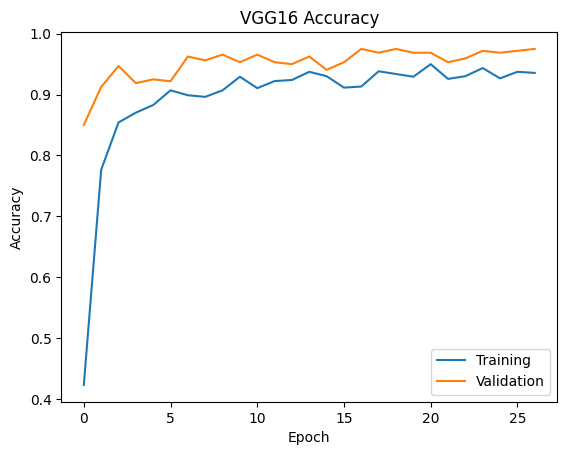

In [ ]:
plt.plot(vgg_history.history['accuracy'], label='Training')
plt.plot(vgg_history.history['val_accuracy'], label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("VGG16 Accuracy")
plt.legend()

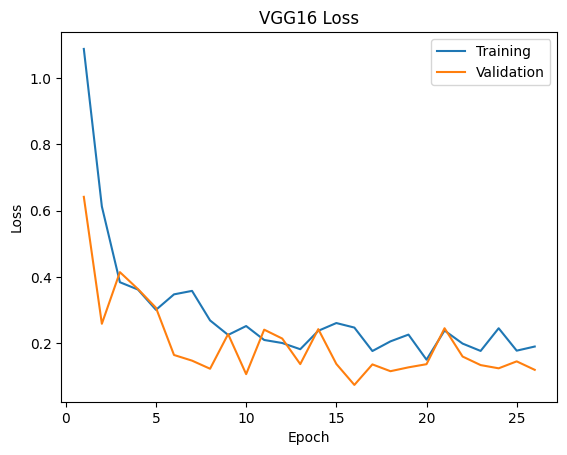

In [ ]:
plt.plot(range(1,27), vgg_history.history['loss'][1:], label='Training')
plt.plot(range(1,27), vgg_history.history['val_loss'][1:], label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("VGG16 Loss")
plt.legend()

In [ ]:
# Evaluasi model
score = vgg_model.evaluate(validgen, verbose=0)
print('Test accuracy:', score[1])

Test accuracy: 0.975683867931366


In [ ]:
tensorflow.keras.saving.save_model(vgg_model, '/content/drive/MyDrive/VGG16_TF_model.h5')